# Causal Inference full spec(因果推論フルスペック)
## we can do Causal Inference with this python program

In [116]:
#ＲＥＦＥＲＥＮＣＥ↓（参考にさせていただいた記事）
#https://qiita.com/usaito/items/09daccdd91bc98c21dff

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Reading data and Aggregating(データ読み込み＆集計)

In [4]:
# READING
data_df = pd.read_csv('https://github.com/iwanami-datascience/vol3/raw/master/kato%26hoshino/q_data_x.csv')
data_df.head()

# Cross-tabulation of application usage dummy and CM viewing(アプリ利用ダミーとCM視聴有無のクロス集計)
pd.crosstab(data_df.gamedummy, data_df.cm_dummy)

cm_dummy,0,1
gamedummy,,
0,5428,3832
1,428,312


In [5]:
# CM視聴有無でのアプリ利用回数の差を計算
data_df[data_df.cm_dummy == 1].gamecount.mean() - data_df[data_df.cm_dummy == 0].gamecount.mean()

-1.4845493913116865

In [6]:
# CM視聴有無でのアプリ利用時間の差を計算
data_df[data_df.cm_dummy == 1].gamesecond.mean() - data_df[data_df.cm_dummy == 0].gamesecond.mean()

-629.6405765396544

In [7]:
data_df[:10]

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,...,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,...,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,1,0,0,49.344942,0,0
5,0,0,0,1,0,0,24.5,0,0,0,...,0,1,0,0,0,0,0,48.417899,0,0
6,0,0,0,0,0,1,19.0,0,0,0,...,1,0,0,0,0,0,0,53.426757,0,0
7,0,0,0,0,1,0,54.5,0,1,1,...,0,0,0,1,0,0,0,56.697458,0,0
8,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,61.996340,0,0
9,0,0,0,1,0,0,34.5,1,0,1,...,0,0,0,0,1,0,0,64.557893,0,0


In [19]:
import pandas_profiling as pdp
pdp.ProfileReport(data_df)

Number of variables,35
Number of observations,10000
Total Missing (%),0.0%
Total size in memory,2.7 MiB
Average record size in memory,280.0 B
Numeric,6
Categorical,0
Boolean,29
Date,0
Text (Unique),0
Rejected,0


# 傾向スコアの算出＆評価

In [24]:
from sklearn.linear_model import LogisticRegression

In [48]:
# 説明変数
cols = ["age", "sex", "TVwatch_day", "marry_dummy", "child_dummy", "inc", "pmoney",
        "area_kanto", "area_tokai", "area_keihanshin",
        "job_dummy1", "job_dummy2", "job_dummy3", "job_dummy4", "job_dummy5", "job_dummy6",
        "fam_str_dummy1", "fam_str_dummy2", "fam_str_dummy3", "fam_str_dummy4"]
X = data_df[cols].copy()

# 切片の導入
X.loc[:, "Intercept"] = 1

# CM視聴有無ダミー
z1 = data_df.cm_dummy

# 目的変数群（1:アプリ利用ダミー, 2:アプリ利用回数、3:アプリ利用時間）
y1 = data_df.gamedummy
y2 = data_df.gamecount
y3 = data_df.gamesecond

#モデルの生成
clf = LogisticRegression(C=10000)
#学習
clf.fit(X,z1)
#モデルに伴う生存率の予測値
ps = clf.predict_proba(X)

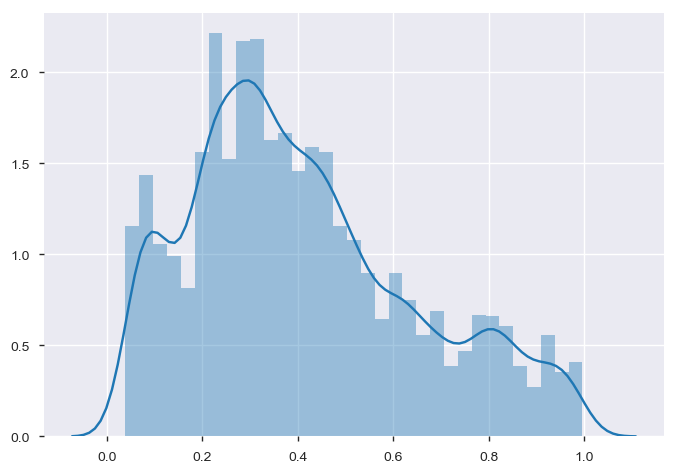

In [65]:
import seaborn as sns
sns.distplot(ps[:,1])

In [69]:
from sklearn.metrics import roc_curve
from sklearn import metrics

fpr, tpr, thresholds = roc_curve(z1, ps[:,1])
metrics.auc(fpr, tpr)

#------------------------------------
#0.8以上	効果がすごくいい
#0.7-0.8	効果があります
#0.6-0.7	効果が多少あります
#0.5-0.6	効果がありません
#------------------------------------

0.7836189114685529

# Computing ATE (平均介入効果(ＡＴＥ)の算出)

In [74]:
ps1 =  ps[:,1]

In [107]:
z1a =  np.array(z1)
y1a =  np.array(y1)
y2a =  np.array(y2)
y3a =  np.array(y3)

In [112]:
#傾向スコアを加味せず、単純に効果をひく。
n_ipwe11 = sum((z1a * y1a)) / sum(z1a )  # 介入群＝z1aが１のデータ。
n_ipwe10 = sum(((1 - z1a) * y1a)) / sum((1 - z1a))  # 統制群＝# 介入群＝z1aが0のデータ。
n_ATE1 = n_ipwe11 - n_ipwe10

#介入により、アプリ利用有無に変化があったと言えるか？
# IPWによりアプリ利用ダミーへのATEを推定
ipwe11 = sum((z1a * y1a) / ps1) / sum(z1a / ps1)  # 介入群＝z1aが１のデータ。
ipwe10 = sum(((1 - z1a) * y1a) / (1 - ps1)) / sum((1 - z1a) / (1 - ps1))  # 統制群＝# 介入群＝z1aが0のデータ。
ATE1 = ipwe11 - ipwe10

print(n_ATE1)
print(ATE1)

0.002202143595586223
0.031938505081500326


In [113]:
#傾向スコアを加味せず、単純に効果をひく。
n_ipwe21 = sum((z1a * y2a)) / sum(z1a )  # 介入群＝z1aが１のデータ。
n_ipwe20 = sum(((1 - z1a) * y2a)) / sum((1 - z1a))  # 統制群＝# 介入群＝z1aが0のデータ。
n_ATE2 = n_ipwe21 - n_ipwe20

#介入により、アプリ利用回数に変化があったと言えるか？
# IPWによりアプリ利用ダミーへのATEを推定
ipwe21 = sum((z1a * y2a) / ps1) / sum(z1a / ps1)  # Treated
ipwe20 = sum(((1 - z1a) * y2a) / (1 - ps1)) / sum((1 - z1a) / (1 - ps1))  # Control
ATE2 = ipwe21 - ipwe20

print(n_ATE2)
print(ATE2)

-1.4845493913116865
4.18725183238292


In [115]:
#傾向スコアを加味せず、単純に効果をひく。
n_ipwe31 = sum((z1a * y3a)) / sum(z1a )  # 介入群＝z1aが１のデータ。
n_ipwe30 = sum(((1 - z1a) * y3a)) / sum((1 - z1a))  # 統制群＝# 介入群＝z1aが0のデータ。
n_ATE3 = n_ipwe31 - n_ipwe30

#介入により、アプリ利用時間に変化があったと言えるか？
# IPWによりアプリ利用ダミーへのATEを推定
ipwe31 = sum((z1a * y3a) / ps1) / sum(z1a / ps1)  # Treated
ipwe30 = sum(((1 - z1a) * y3a) / (1 - ps1)) / sum((1 - z1a) / (1 - ps1))  # Control
ATE3 = ipwe31 - ipwe30

print(n_ATE3)
print(ATE3)

-629.6405765396544
934.4221365398948


# UpliftModeling